# 1. Preanalyzing Data Set
Missingo is a great python library to visualize missing value. 

In [1]:
conda install -c conda-forge/label/gcc7 missingno

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import math
import re
from decimal import Decimal

import pandas as pd
import numpy as np

import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OneHotEncoder

## Checking training data set

I explore the table and count the number of rows and columns. In addition, I have a quick look of the data by spotting the first 5 rows to identify the right steps to do.


In [3]:
df_train = pd.read_csv("auto-insurance-fall-2017/train_auto.csv")
df_test = pd.read_csv("auto-insurance-fall-2017/test_auto.csv")

In [4]:
df_train.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [5]:
df_train.shape

(8161, 26)

In [6]:
# Index variable
index_field = 'INDEX'

# Target Variable
y_variable = 'TARGET_FLAG'
delete_redundant_y = 'TARGET_AMT'

There are 8169 rows and 26 columns of which TARGET_FLAG is the target variable and INDEX is just a field I can drop as it does not provide any information to the analysis. TARGET_AMT is also removed as it is repetitive with target variable.

In [7]:
df_train = df_train.drop([index_field,delete_redundant_y], axis = 1)
df_test = df_test.drop([index_field,delete_redundant_y], axis = 1)

## Target variable

In [8]:
# Calculate how balance is the dataset
balance_target = df_train[y_variable].mean()
print(balance_target)

0.2638157088592084


There is not a great unbalanced in the target variable as the proportion is 1 positive case to 3 negative case (according to specialized literature less than 10-20% is considered unbalanced). In principle, we could consider Accuracy as the target variable but we might be forgetting about the business side of the problem. For an Insurance company, a claim is the greatest liability of the company. Therefore, we want to avoide as much as possible False Negative. Thus, I select **AUC score as the KPI (performance metric) for this project**. Based on the need of the client, the selection of a threshold is defined afterwards.

## Numeric variables

I make the difference between float and integer variables

In [9]:
float_variables_idx = np.where((df_train.dtypes == np.float))[0] 

In [10]:
int_variables_idx = np.where((df_train.dtypes == np.int))[0]

## Non numeric variables

I identify the variables with non numeric variables and I define a proper strategy for each one

In [11]:
non_num_idx = np.where((df_train.dtypes != np.float) & (df_train.dtypes != np.int))[0] 

In [12]:
df_train.iloc[:, non_num_idx].head()

,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,BLUEBOOK,CAR_TYPE,RED_CAR,OLDCLAIM,REVOKED,URBANICITY
0,"$67,349",No,$0,z_No,M,PhD,Professional,Private,"$14,230",Minivan,yes,"$4,461",No,Highly Urban/ Urban
1,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,Commercial,"$14,940",Minivan,yes,$0,No,Highly Urban/ Urban
2,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,Private,"$4,010",z_SUV,no,"$38,690",No,Highly Urban/ Urban
3,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,Private,"$15,440",Minivan,yes,$0,No,Highly Urban/ Urban
4,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,Private,"$18,000",z_SUV,no,"$19,217",Yes,Highly Urban/ Urban


### Money variables

Have identified money variables, I proceed to convert them into float.

In [13]:
Money_variables = ['INCOME',
                   'HOME_VAL',
                   'BLUEBOOK',
                   'OLDCLAIM'
                  ]

def replace_money_value(money):
    """
        Given a string representing money, return float representation.
    """
    if type(money) is not str and math.isnan(money):
        return np.nan
    else:
        return float(Decimal(re.sub(r'[^\d.]', '', money)))
    

# It is very likely to have outliters so we reduce this effect by using a logarithmic transformation
    
for column in Money_variables:
    df_train.loc[:, column] = df_train.loc[:, column].apply(replace_money_value)
    df_train.loc[:, column] = df_train.loc[:, column].apply(np.log)
    df_train.loc[:, column] = df_train.loc[:, column].replace({-np.inf: 1})
    df_test.loc[:, column] = df_test.loc[:, column].apply(replace_money_value)
    df_test.loc[:, column] = df_test.loc[:, column].apply(np.log)
    df_test.loc[:, column] = df_test.loc[:, column].replace({-np.inf: 1})
   
df_train.loc[:, Money_variables].head()

,INCOME,HOME_VAL,BLUEBOOK,OLDCLAIM
0,11.117643,1.000000,9.563108,8.403128
1,11.423537,12.457811,9.611797,1.000000
2,9.682779,11.729576,8.296547,10.563336
3,NaN,12.632160,9.644717,1.000000
4,11.652566,12.404616,9.798127,9.863551


### Binary variables

Having identified binary variables, it is recommended to map it into zeros and ones to perform mathematical operations.

In [14]:
Binary_variables = ['PARENT1',
                    'MSTATUS',
                    'RED_CAR',
                    'REVOKED',
                    'SEX']

Binary_values = {'No'  : 0,
                 'z_No': 0,
                 'no'  : 0,
                 'Yes' : 1,
                 'yes' : 1,
                 }

for column in Binary_variables:
    df_train.loc[:, column] = df_train.loc[:, column].replace(Binary_values)
    df_test.loc[:, column] = df_test.loc[:, column].replace(Binary_values)
    
df_train.loc[:, Binary_variables].head()

,PARENT1,MSTATUS,RED_CAR,REVOKED,SEX
0,0,0,1,0,M
1,0,0,1,0,M
2,0,1,0,0,z_F
3,0,1,1,0,M
4,0,1,0,1,z_F


### Ordinal variables

Education can be organized in the following order: "<High School","High School", "Bachelors", Masters" , "PhD".
**I am supposing that 'z_High School' is higher than  '<High School'**

In [15]:
Ordinal_variables = 'EDUCATION'

df_train.loc[:, Ordinal_variables].replace({'<High School':  0,
                                'z_High School': 1,
                                'Bachelors'   : 2,
                                'Masters'     : 3,
                                'PhD'         : 4}, inplace=True)
df_test.loc[:, Ordinal_variables].replace({'<High School':  0,
                                'z_High School': 1,
                                'Bachelors'   : 2,
                                'Masters'     : 3,
                                'PhD'         : 4}, inplace=True)

df_train.loc[:, [Ordinal_variables]].head()

,EDUCATION
0,4
1,1
2,1
3,0
4,4


### Nominal Variables

For the rest of the variables, it is performed one hot encoding.

The columns 'JOB', 'CAR_TYPE' have multiple modes, we will define a one hot encoding to map the columns into one hot vectors.

In [16]:
Nominal_variables = ['SEX',
                     'JOB',
                     'CAR_USE',
                     'CAR_TYPE',
                     'URBANICITY']


**SEX** is a variable with two categories, **URBANICITY** is a variable with two categories, **CAR_TYPE** is a variable with six categories, **CAR_TYPE** is a variable with two categories, **JOB** is a variable with 8 categories. We use prebuilt OneHotEncoder function from scikit learn. **JOB** variable has some missing values so before the one hot encoding procedure, I replace missing values by most common Job 'z_Blue Collar'

In [17]:
df_train.loc[:, 'JOB'].fillna('z_Blue Collar', inplace=True)
df_test.loc[:, 'JOB'].fillna('z_Blue Collar', inplace=True)

In [18]:
enc = OneHotEncoder(handle_unknown='ignore')
Enconding_values = enc.fit_transform(df_train[Nominal_variables]).toarray()
Categories = np.concatenate(enc.categories_, axis=0).tolist()
New_columns = pd.DataFrame(Enconding_values,columns = Categories)

Enconding_values = enc.fit_transform(df_test[Nominal_variables]).toarray()
New_columns_test = pd.DataFrame(Enconding_values,columns = Categories)

New_columns.head()

,M,z_F,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar,Commercial,Private,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Highly Urban/ Urban,z_Highly Rural/ Rural
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In the following notebooks, I will use linear models. I remove one category for each original variable to avoid multicolinearity. 'z_F' for **SEX**, 'z_Blue Collar' for **JOB**, 'Private' for **CAR_USE**, 'z_SUV' for **CAR_TYPE** and 'z_Highly Rural/Rural' for **URBANICITY**. I remove original nominal variables from df_train and add the new variables.

In [19]:
New_columns = New_columns.drop(['z_F', 'z_Blue Collar','Private','z_SUV','z_Highly Rural/ Rural'], axis=1)
df_train = df_train.drop(Nominal_variables, axis = 1)
df_train = pd.concat([df_train, New_columns], axis=1)

New_columns_test = New_columns_test.drop(['z_F', 'z_Blue Collar','Private','z_SUV','z_Highly Rural/ Rural'], axis=1)
df_test = df_test.drop(Nominal_variables, axis = 1)
df_test = pd.concat([df_test, New_columns_test], axis=1)

df_train.head(10)

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,EDUCATION,...,Manager,Professional,Student,Commercial,Minivan,Panel Truck,Pickup,Sports Car,Van,Highly Urban/ Urban
0,0,0,60.0,0,11.0,11.117643,0,1.000000,0,4,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,0,43.0,0,11.0,11.423537,0,12.457811,0,1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35.0,1,10.0,9.682779,0,11.729576,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,51.0,0,14.0,NaN,0,12.632160,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,0,50.0,0,NaN,11.652566,0,12.404616,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1,0,34.0,1,12.0,11.738474,1,1.000000,0,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6,0,0,54.0,0,NaN,9.839216,0,NaN,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1,1,37.0,2,NaN,11.589525,0,12.717938,1,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8,1,0,34.0,0,10.0,11.050541,0,1.000000,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,0,50.0,0,7.0,11.580135,0,1.000000,0,2,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Missing Values
In the next step, I will identify the missing variables with **missingo** to understand if the missing values are random or they have any pattern within the variables.

<AxesSubplot:>

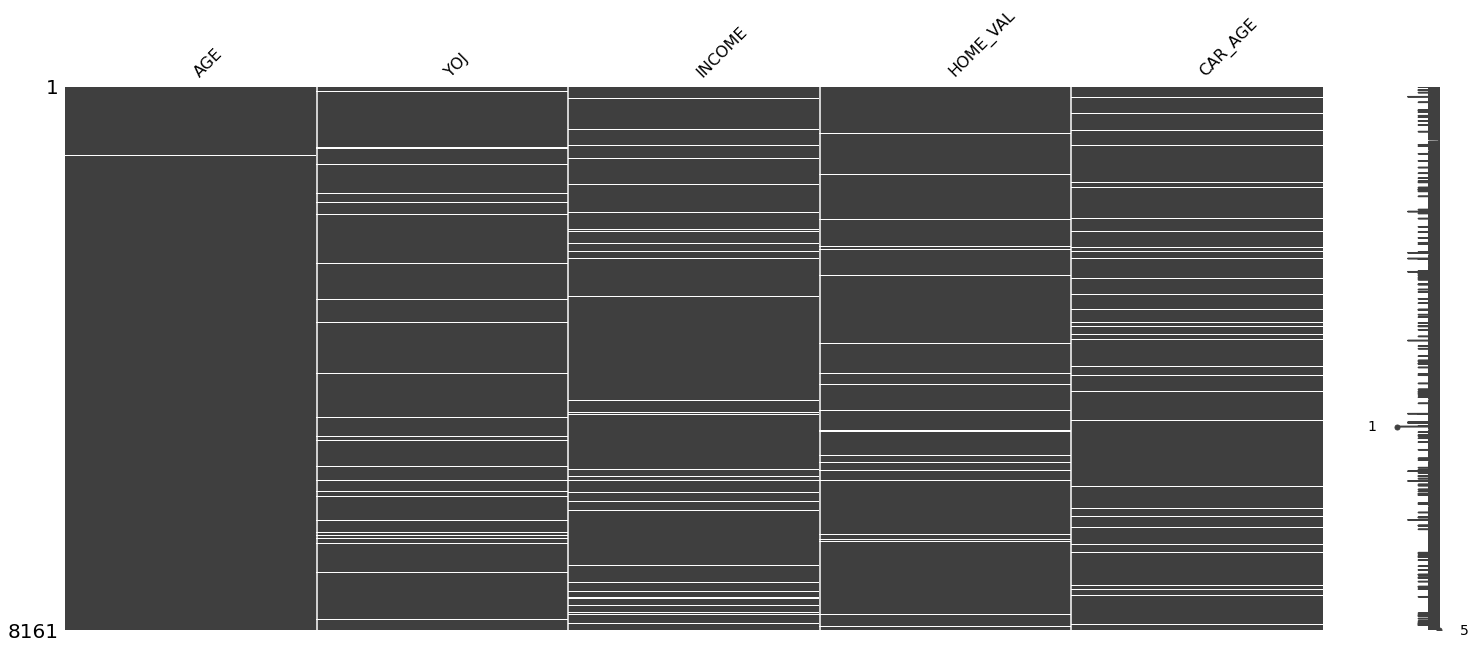

In [20]:
variable_with_missing = df_train.isna().sum()
variable_with_missing = list(variable_with_missing[variable_with_missing != 0].index)
msno.matrix(df_train[variable_with_missing])


<AxesSubplot:>

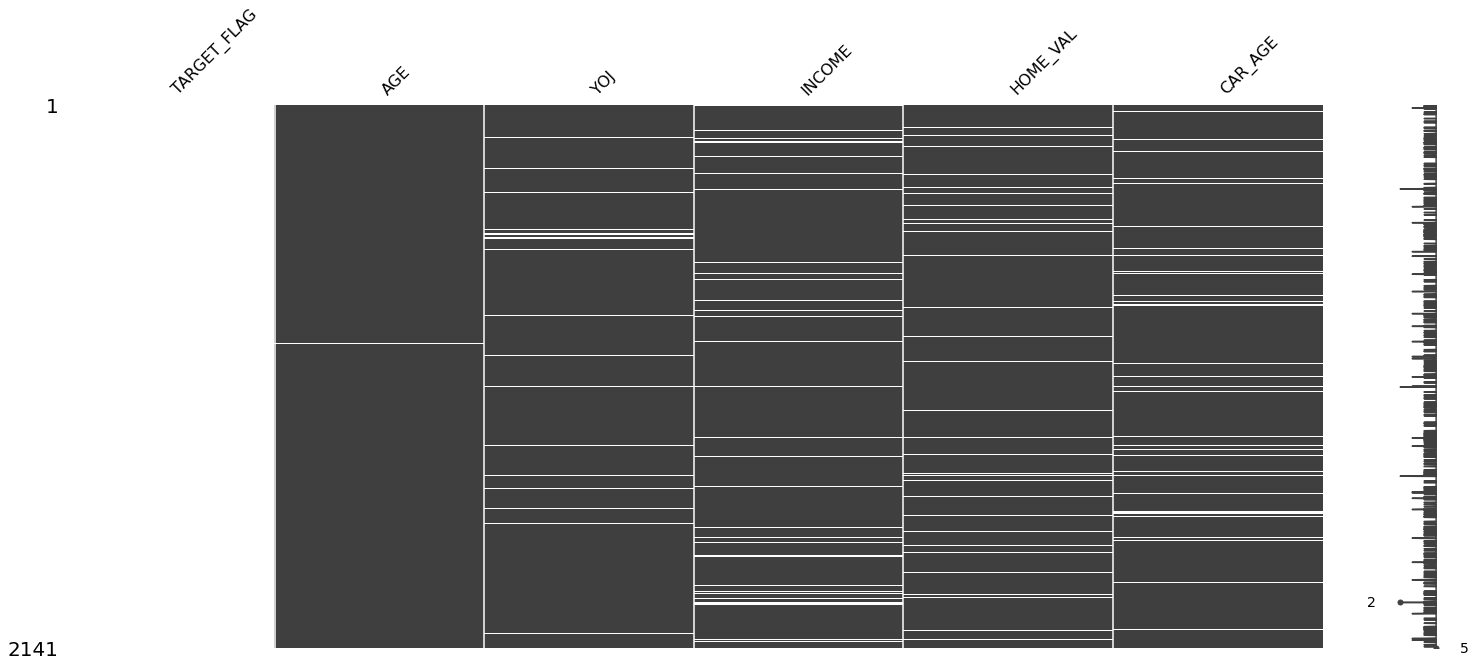

In [21]:
variable_with_missing = df_test.isna().sum()
variable_with_missing = list(variable_with_missing[variable_with_missing != 0].index)
msno.matrix(df_test[variable_with_missing])

From the matrix below, it is clear that missing values are randomly spread between variables. There is no relationship in missing values between the 6 different variables. As there is no previous knowledge from the Data set, I take the decision to do imputation using the mean. This decision is based on simplicity the code and explanability for the final client. **KNN** might be used to find a more accurate missing value. It is important to notize that we are imputing test data set with values of training.

In [23]:
variable_with_missing
for i in variable_with_missing:
    df_train.loc[df_train.loc[:,i].isnull(),i]=df_train.loc[:,i].mean()
    if i != y_variable:
        df_test.loc[df_test.loc[:,i].isnull(),i]=df_train.loc[:,i].mean()

# Summary

In this notebook, I explore the dataset and I prepare the data set for exploratory and descriptive statistics.

* I define the target variable and drop  variables not relevant for the next notebooks.

* I transform the variables depending on its type and its future purpose

* I perform one hot encoding with nominal variables

* I review missing values and impute based on mean method.

In [24]:
new_dir = 'Working_datasets'

if not os.path.exists(new_dir):
    os.mkdir(new_dir)
    
df_train.to_csv(os.path.join(new_dir, 'preprocessed_train.csv'), index=None)
df_test.to_csv(os.path.join(new_dir, 'preprocessed_test.csv'), index=None)